# Time series analysis using Pandas

A very common data anlysis task you'll encounter is time series analysis, which involves the study of variables over time. In this practice we will review several Pandas features that are essential to completing time series analysis. 

## Loading in some time series data 

To practice working with time series data, we will load in the file `monthly-beer-production-in-austr-edit.csv`, which contains data on beer production in Australia given in hectoliters. Let's use pandas to read this csv file in. 

In [71]:
import pandas as pd

beer = pd.read_csv('monthly-beer-production-in-austr-edit.csv')
beer.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


## Pre-analysis checks 

Before begining analysis it is typically a good idea to inspect the data itself. This will give us a chance to identify any odd values, potential data errors, or missing values we may have to deal with. It's better to check & fix these things in the very beginnign than to wait until later when we realized our analysis results look off.

A simple start is to use the `describe` method, which should give us a few summary statistics for our data. 

In [72]:
beer['Month'].describe()

count         476
unique        476
top       1993-09
freq            1
Name: Month, dtype: object

First off, we see that the count and the number of unique values are equal, which is a good sign. We know we should have one entry for each unique date in our time range. But we also see that the datatype is `object`. We should convert this to datetime using `pd.to_datetime` before proceeding. This is not only necessary for using some of the time series analysis tools, but also for best results when creating plots. 

In [73]:
beer['Month'] =  pd.to_datetime(beer['Month'], format='%Y-%m')

Now let's check out our second column, which contains beer production in hectoliters. 

In [74]:
beer['Monthly beer production'].describe()

count     476
unique    385
top       143
freq        5
Name: Monthly beer production, dtype: object

The data type is `object`, which isn't ideal. We want to be able to treat these values as numbers. Let's convert to a numeric format. 

In [75]:
beer['Monthly beer production'] = pd.to_numeric(beer['Monthly beer production'])

ValueError: Unable to parse string "80.4.00" at position 16

Hmm looks like we have a problem! There seems to be at least one value with an incorrect format - no number should have two decimal points! Let's find where these values exist and replace them with a fill-value, `None`. 

Then, we can try to convert to numeric again. 

In [76]:
for ind, row in beer.iterrows():
    count_decimals = row['Monthly beer production'].count('.')
    if count_decimals > 1:
        beer['Monthly beer production'].iloc[ind] = None 

/Users/sofiarocco/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [77]:
beer['Monthly beer production'] = pd.to_numeric(beer['Monthly beer production'])

When we use `describe` on a numeric column, we get summary statistics which give us an idea of our data values range and behavior. 

In [78]:
beer['Monthly beer production'].describe()

count    474.000000
mean     136.082911
std       35.773328
min     -130.000000
25%      113.000000
50%      139.450000
75%      159.075000
max      217.800000
Name: Monthly beer production, dtype: float64

Hmm... the minimum value is -130. It's not possible to produce a negative amount of beer, so let's investigate. We will look at how many values in the column are negative. If there are a high fraction of negative production values, we know we have a big problem with our data. However if there's just a couple then its likely just a typo and we can `replace` the value and move on. 

In [79]:
# how many rows with negative values?
neg_values = beer[beer['Monthly beer production'] < 0]
len(neg_values)

1

In [80]:
# just one strange value so lets replace that min value with none 
beer['Monthly beer production'].replace(neg_values['Monthly beer production'].values, None, inplace = True)

In [81]:
# and run describe again to make sure it worked 
beer['Monthly beer production'].describe()

count    474.000000
mean     136.643460
std       33.611506
min       64.800000
25%      113.125000
50%      139.450000
75%      159.075000
max      217.800000
Name: Monthly beer production, dtype: float64

## A basic time series plot

Now that we've cleaned up our dataframe, we are ready to begin some time series analysis. Let's start with a simple plot using panda's built in plotting functionality. 

<AxesSubplot:title={'center':'Australia Monthly Beer Production'}, xlabel='Month'>

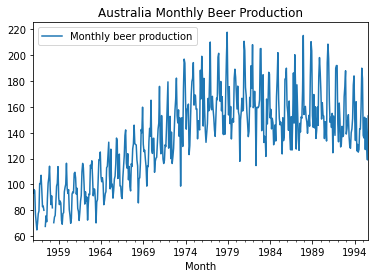

In [82]:
beer.plot(x = 'Month', y = 'Monthly beer production', title = 'Australia Monthly Beer Production')

We can do the same using the matplotlib's pyplot, like so 

Text(0, 0.5, 'Amount Produced [Hectoliters]')

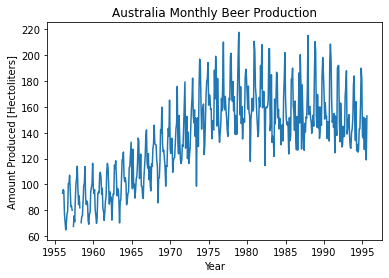

In [83]:
from matplotlib import pyplot as plt

plt.plot(beer['Month'], beer['Monthly beer production'])
plt.title('Australia Monthly Beer Production')
plt.xlabel('Year')
plt.ylabel('Amount Produced [Hectoliters]')

## Resampling 

A popular time series analysis technique you'll need is the ability to **resample** data. This means changing the frequency at which your data is reported. In our `beer` dataframe the data is given monthly, which means there is a single value per month. We could resample this to make it coarser, say a frequency of 1 value per year using `df.resample()`. We do this by applying an operation like `sum` or `mean` to translate the monthly values into yearly values. 

The following uses `mean` to give us yearly average beer production. Note that the `Month` column has been altered as well - it is now the index, and the values changed too. Resampling will change your timestamp value in such a way that it reflects the **end** of the resampling period. 

In [104]:
beer_yearly_avg = beer.resample("Y", on="Month").mean()
beer_yearly_avg.head()

,Monthly beer production
Month,
1956-12-31,86.041667
1957-12-31,87.818182
1958-12-31,88.600000
1959-12-31,87.700000
1960-12-31,90.366667


You'll also notice that the headers in the altered dataframe have been offset. This is because the resampling created what is called a **multiindex** in pandas. Also, see that the column name is still 'monthly' although the timeframe for the data is now 'yearly'. 

You can reset the index & add a new column name like so: 

In [105]:
beer_yearly_avg = beer_yearly_avg.reset_index(level=['Month'])
beer_yearly_avg.rename(columns={"Monthly beer production": "Yearly avg beer production", \
                                "Month": "Year"}, inplace = True)
beer_yearly_avg.head()

,Year,Yearly avg beer production
0,1956-12-31,86.041667
1,1957-12-31,87.818182
2,1958-12-31,88.600000
3,1959-12-31,87.700000
4,1960-12-31,90.366667


You could also chain the re-indexing & column name change to the resampling line to keep your code streamlined, like in the following cell. However, it is up to you how you choose to do this, as chaining too many things together can make code a bit harder to read. 

In [107]:
beer_yearly_avg = beer.resample("Y", on="Month").mean().reset_index(level=['Month']) \
    .rename(columns={"Monthly beer production": "Yearly avg beer production", "Month": "Year"})
beer_yearly_avg.head()

,Year,Yearly avg beer production
0,1956-12-31,86.041667
1,1957-12-31,87.818182
2,1958-12-31,88.600000
3,1959-12-31,87.700000
4,1960-12-31,90.366667


<hr style="border:2px solid gray"> </hr>

### Now you try! 

Apply `.sum()` to the resampling above (rather than `.mean()` to produce a new dataframe, `beer_yearly_sum` which contains yearly total beer production. 

In [87]:
### BEGIN SOLUTION 

beer_yearly_sum = beer.resample("Y", on="Month").sum().reset_index(level=['Month']) \
    .rename(columns={"Monthly beer production": "Yearly sum beer production"})
beer_yearly_sum.head()

### END SOLUTION 

,Month,Yearly sum beer production
0,1956-12-31,1032.5
1,1957-12-31,966.0
2,1958-12-31,974.6
3,1959-12-31,1052.4
4,1960-12-31,1084.4


<hr style="border:2px solid gray"> </hr>

We could even resample on every 3 months, to give us quarterly sums/averages. 

In [88]:
beer_quarterly_avg = beer.resample("3M", on="Month").mean().reset_index(level=['Month']) \
    .rename(columns={"Monthly beer production": "Quarterly avg beer production", "Month": "Quarter"})
beer_quarterly_avg.head()

,Quarter,Quarterly avg beer production
0,1956-01-31,93.200000
1,1956-04-30,89.433333
2,1956-07-31,68.600000
3,1956-10-31,85.800000
4,1957-01-31,101.233333


In [89]:
beer_quarterly_sum = beer.resample("3M", on="Month").sum().reset_index(level=['Month']) \
    .rename(columns={"Monthly beer production": "Quarterly sum beer production", "Month": "Quarter"})
beer_quarterly_sum.head()

,Quarter,Quarterly sum beer production
0,1956-01-31,93.2
1,1956-04-30,268.3
2,1956-07-31,205.8
3,1956-10-31,257.4
4,1957-01-31,303.7


Let's add the yearly resampled mean & quarterly resampled mean to our time series plot to visually demonstrate the change. You'll see that resampling to a coarser timeframe has a **smoothing** effect on the time series! This is helpful as sometimes the level of detail in the original fine timeframe can be distracting from broader trends, or simply is not necessary for the analysis at hand. 

Even in the coarsest time frame we plotted, yearly, we see the same trend of beer production increasing from 1995 to around 1975, leveling off, and then begining to decrase around 1990. 

Text(0, 0.5, 'Amount Produced [Hectoliters]')

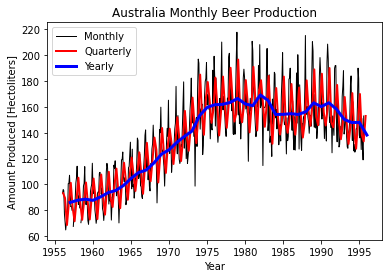

In [90]:
from matplotlib import pyplot as plt

plt.plot(beer['Month'], beer['Monthly beer production'], c = 'k', linewidth = 1, label = 'Monthly')

plt.plot(beer_quarterly_avg['Quarter'], beer_quarterly_avg['Quarterly avg beer production'], c = 'r', 
         linewidth = 2, label = 'Quarterly')

plt.plot(beer_yearly_avg['Year'], beer_yearly_avg['Yearly avg beer production'], c = 'b', 
         linewidth = 3, label = 'Yearly')

plt.legend()
plt.title('Australia Monthly Beer Production')
plt.xlabel('Year')
plt.ylabel('Amount Produced [Hectoliters]')

This can also be accomplished with pandas' `asfreq` function, which behaves similarly to `resample`. 

## Shifting 

Another useful tool is the ability to **shift** time series data. This is handy when you want to compare each value to the year (or month, day, second, ...) prior. We noticed in the previous plot an increase, level off, then decrease in beer production. We could use `shift` to create a plot that shows just that. 

Applying `.shift(1)` to our dataframe will create a new column that shifts all values forward one timestep. Using -1 will shift backwards one timestep, and using 5 will shift forward 5 timesteps, and so on. For now we will only shift by a single year in our `beer_yearly_avg` dataframe.

In [103]:
beer_yearly_avg["production_lag1"] = beer_yearly_avg['Yearly avg beer production'].shift(1)
beer_yearly_avg.head()

,Yearly avg beer production,production_lag1,production_diff
Year,,,
1956-12-31,NaN,NaN,NaN
1957-12-31,NaN,NaN,NaN
1958-12-31,NaN,NaN,NaN
1959-12-31,NaN,NaN,NaN
1960-12-31,88.105303,NaN,NaN


We can use this new column to then easily calculate the difference between beer production from one year to the next - a positive `production_diff` means more beer was produced than the year before, and a negative means less was produced. 

In [96]:
beer_yearly_avg["production_diff"] = beer_yearly_avg['Yearly avg beer production'] - \
    beer_yearly_avg['production_lag1']
beer_yearly_avg.head()                                                                                            

,Year,Yearly avg beer production,production_lag1,production_diff
0,1956-12-31,86.041667,NaN,NaN
1,1957-12-31,87.818182,86.041667,1.776515
2,1958-12-31,88.600000,87.818182,0.781818
3,1959-12-31,87.700000,88.600000,-0.900000
4,1960-12-31,90.366667,87.700000,2.666667


We can plot the resulting difference with a horizontal line at zero, where any value above the line means that year indicates an increase in production, and any value below the line indicates a decrease in  production. 

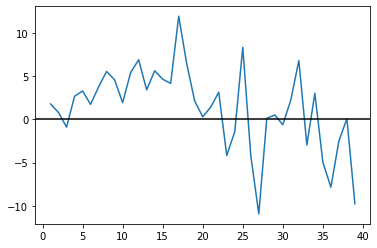

In [97]:
plt.plot(beer_yearly_avg["production_diff"])
plt.axhline(y=0, c = 'k')

<hr style="border:2px solid gray"> </hr>

### Now you try! 

Add a `production_diff` column to `beer_yearly_sum` that shows the difference between that year's production and the production two years prior. Print the first 5 rows of the altered dataframe. 

In [98]:
### BEGIN SOLUTION 

beer_yearly_sum['production_lag2'] = beer_yearly_sum['Yearly sum beer production'].shift(2)
beer_yearly_sum["production_diff"] = beer_yearly_avg['Yearly avg beer production'] - \
    beer_yearly_sum['production_lag2']

beer_yearly_sum.head()

### END SOLUTION 

,Month,Yearly sum beer production,production_lag2,production_diff
0,1956-12-31,1032.5,NaN,NaN
1,1957-12-31,966.0,NaN,NaN
2,1958-12-31,974.6,1032.5,-943.900000
3,1959-12-31,1052.4,966.0,-878.300000
4,1960-12-31,1084.4,974.6,-884.233333


<hr style="border:2px solid gray"> </hr>

## Rolling average windows

Another useful tool is the ability to create a **rolling average** otherwise known as a moving average. This means computing an average for a defined window over and over again, passing through all the values. So say your window size was 3, you'd average values 1-3, then 2-4, then 3-5, etc. until you run out of values. This essentially batches your values in groups of 3 (or whatever window you choose). [This article](https://www.portent.com/blog/analytics/rolling-averages-math-moron.htm_) explains the concept in a bit more detail. 

We can do this using the `.rolling()` method in pandas. By default, this method will average the value of timestep & the input number of values (window size) previous. The number you put inside the parentheses defines your window size. For now we will average 4 years at a time. You need to add `set_index` to retain the Year as the index in the returned dataframe (it will work if you exclude this, you'll just lose that column). You will also chain the `mean` command at the end to get the average of each window. 

You'll notice that `beer_yearly_avg_rolling` has `NaN` for the first three values. This is because the method is trying to average each value & the three previous, but there are no three previous values. Therefore the method skips these. 

In [141]:
# recreate beer_yearly_average
beer_yearly_avg = beer.resample("Y", on="Month").mean().reset_index(level=['Month']) \
    .rename(columns={"Monthly beer production": "Yearly avg beer production", "Month": "Year"})

# compute rolling average 
beer_yearly_avg_rolling = beer_yearly_avg.set_index("Year").rolling(4).mean()
beer_yearly_avg_rolling.reset_index(level=['Year'], inplace = True)
beer_yearly_avg_rolling.head()

,Year,Yearly avg beer production
0,1956-12-31,NaN
1,1957-12-31,NaN
2,1958-12-31,NaN
3,1959-12-31,87.539962
4,1960-12-31,88.621212


You can plot this rolling average to see the smoothing effect like so

Text(0, 0.5, 'Amount Produced [Hectoliters]')

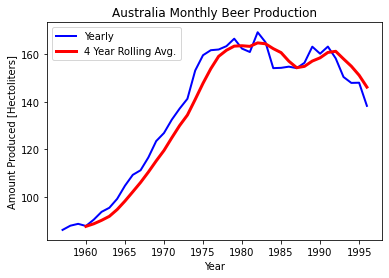

In [142]:
plt.plot(beer_yearly_avg['Year'], beer_yearly_avg['Yearly avg beer production'], c = 'b', 
         linewidth = 2, label = 'Yearly')

plt.plot(beer_yearly_avg_rolling['Year'], beer_yearly_avg_rolling['Yearly avg beer production'], c = 'r', 
         linewidth = 3, label = '4 Year Rolling Avg.')

plt.legend()
plt.title('Australia Monthly Beer Production')
plt.xlabel('Year')
plt.ylabel('Amount Produced [Hectoliters]')

An alterative to rolling window analysis is the use of **expanding** windows, as shown [here](https://www.w3resource.com/pandas/series/series-expanding.php#:~:text=Expanding%20transformations%20in%20Pandas,used%20to%20provide%20expanding%20transformations.&text=Minimum%20number%20of%20observations%20in,(otherwise%20result%20is%20NA).&text=Set%20the%20labels%20at%20the%20center%20of%20the%20window.). An expanding window should be used when we want to get the statistic (mean, sum, etc) for **all data up to a certain point in time**. 

## Time offsets 

Besides the smoothing effect of the rolling average, you might notice that the rolling average seems to be offset to the right of the yearly values. This is because by default, `rolling` sets the window labels (dates) as the right edge of the window index, in other words the end of the rolling period. 

One way to fix this is by adding the `cetner = True` parameter in the `rolling` method, which sets window labels as the center of the window index, rather than the right. 

Another way to do this, which can be applied to a resampled dataframe as well, is to add a **time offset**. Pandas has an entire package that has tools to help you handle time series, and you can call it in using `import pandas.tseries.frequencies` to explore the tools within. For now, we will import only the `to_offset` method as this will help us solve our offset problem.

The `loffset` variable should be set to **half** your window - in this case our window = 4, so we will use `loffset = '2Y'` or two years. We subtract this offset from our `Year` column, to add a new offset column. We can then use that column to produce plots that do not have the time shift caused by the resampling/rolling. 

In [139]:
from pandas.tseries.frequencies import to_offset

loffset = '2Y'
beer_yearly_avg_rolling['Year_offset'] = beer_yearly_avg_rolling['Year'] - to_offset(loffset)
beer_yearly_avg_rolling.head()

,Year,Yearly avg beer production,Year_offset
0,1956-12-31,NaN,1954-12-31
1,1957-12-31,NaN,1955-12-31
2,1958-12-31,NaN,1956-12-31
3,1959-12-31,87.539962,1957-12-31
4,1960-12-31,88.621212,1958-12-31


Text(0, 0.5, 'Amount Produced [Hectoliters]')

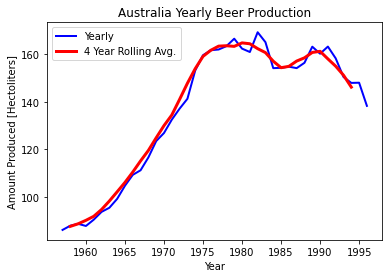

In [140]:
plt.plot(beer_yearly_avg['Year'], beer_yearly_avg['Yearly avg beer production'], c = 'b', 
         linewidth = 2, label = 'Yearly')

plt.plot(beer_yearly_avg_rolling['Year_offset'], beer_yearly_avg_rolling['Yearly avg beer production'], c = 'r', 
         linewidth = 3, label = '4 Year Rolling Avg.')

plt.legend()
plt.title('Australia Yearly Beer Production')
plt.xlabel('Year')
plt.ylabel('Amount Produced [Hectoliters]')

<hr style="border:2px solid gray"> </hr>

# Practice on your own 

In this practice section you will work on time series data that shows industrial electricity production, stored in the file `'Electric_Production_edit.csv'`. 

#### Exercise 1. Read in the data from the `IPG2211A2N_edit.csv` file, adapted from [here](https://fred.stlouisfed.org/series/IPG2211A2N). Rename the `IPG2211A2N` column `Electric Production Index`. Print the summary statistics. 

In [240]:
### BEGIN SOLUTION 

electric = pd.read_csv('IPG2211A2N_edit.csv')
electric.rename(columns={"IPG2211A2N": "Electric Production Index"}, inplace = True)
electric.describe()
electric.head()

### END SOLUTION 

,DATE,Electric Production Index
0,1939-01-01,3.3335
1,1939-02-01,3.3590
2,1939-03-01,3.4353
3,1939-04-01,3.4607
4,1939-05-01,3.4607


#### Exercise 2. Identify what the 'fill value' is in this data set, and replace it with `None`. A fill value is usually something like `NaN`, or a value that is obviously nonsense to indicate it should be removed/replaced. Also, make sure the column containing dates is in datetime format. 

In [241]:
### BEGIN SOLUTION 

electric["Electric Production Index"].replace(float(-999), None, inplace = True)
electric['DATE'] = pd.to_datetime(electric['DATE'], format='%Y-%m-%d')
electric["Electric Production Index"].describe() 

### END SOLUTION 

count    1002.000000
mean       55.466419
std        35.497916
min         3.333500
25%        20.255500
50%        55.613050
75%        88.235750
max       126.527300
Name: Electric Production Index, dtype: float64

#### Exercise 3. Create a plot showing electricity production over time, using the original time resolution. Overlay a plot of data that has been transformed to show decade-long averages of electicity production. Note that for resampling to work, the datetime must be the **index** of the dataframe. 

Text(0, 0.5, 'Electric Production Index')

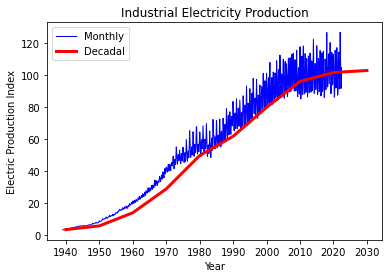

In [242]:
### BEGIN SOLUTION 

plt.plot(electric['DATE'], electric["Electric Production Index"], c = 'b', 
         linewidth = 1, label = 'Monthly')

electric_decade = electric.set_index('DATE').resample('10Y').mean()
plt.plot(electric_decade.index, electric_decade["Electric Production Index"], c = 'r', 
linewidth = 3, label = 'Decadal')

plt.legend()
plt.title('Industrial Electricity Production')
plt.xlabel('Year')
plt.ylabel('Electric Production Index')

### END SOLUTION 

#### Exercise 4. Why is there a visible offset between the monthly and decadal averages? Fix this so the offset is gone in the graph. 

Text(0, 0.5, 'Electric Production Index')

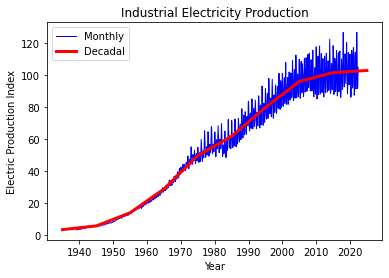

In [243]:
### BEGIN SOLUTION 

# the offset is caused by the resampled data being re-indexed using the rightmost value in the time window 

electric_decade.reset_index(inplace = True)
loffset = '5Y'
electric_decade['DATE_offset'] = electric_decade['DATE'] - to_offset(loffset)

# plot 
plt.plot(electric['DATE'], electric["Electric Production Index"], c = 'b', 
         linewidth = 1, label = 'Monthly')

plt.plot(electric_decade['DATE_offset'], electric_decade["Electric Production Index"], c = 'r', 
linewidth = 3, label = 'Decadal')

plt.legend()
plt.title('Industrial Electricity Production')
plt.xlabel('Year')
plt.ylabel('Electric Production Index')

### END SOLUTION 

#### Exercise 5. Create a plot showing the change in energy production from decade to decade. 

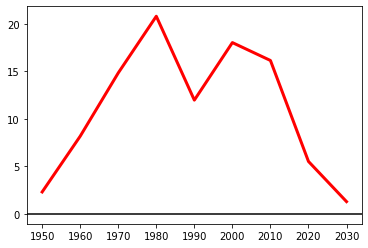

In [244]:
### BEGIN SOLUTION 

electric_decade['Electric Production Index - lag 1'] = electric_decade['Electric Production Index'].shift(1)
electric_decade['Decadal Diff'] = electric_decade['Electric Production Index'] - electric_decade['Electric Production Index - lag 1']

plt.plot(electric_decade['DATE'], electric_decade["Decadal Diff"], c = 'r', 
    linewidth = 3, label = 'Decadal')
plt.axhline(y=0, c = 'k')

### END SOLUTION 

#### Exercise 6. We want to know the total energy produced throughout the timeframe of our data. Compute a rolling sum for this dataset, with a window of 24 months. 

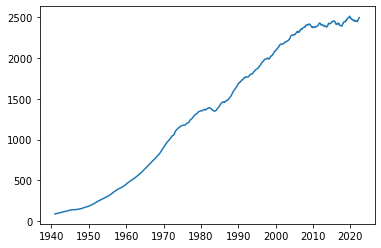

In [245]:
### BEGIN SOLUTION 

electric.set_index('DATE', inplace = True)
electric_rolling = electric2.rolling(24).sum()
plt.plot(electric_rolling)

### END SOLUTION 